In [1]:
#from absl import logging
import tensorflow as tf
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import collections
import numpy as np
import tensorflow.keras.layers as layers
from tqdm import tqdm
from itertools import cycle
from model import build_model

In [2]:
resolution = (256,256)
num_slots = 7
num_iterations = 3
batch_size = 8

model = build_model(resolution, batch_size, num_slots, num_iterations)

2022-11-14 23:13:39.495093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 23:13:39.497995: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
model.summary()

Model: "Slot_Attention_AutoEnconder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_cnn (Sequential)       (None, 256, 256, 64  312256      ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 soft_position_embed (SoftPosit  (None, 256, 256, 64  320        ['encoder_cnn[0][0]']            
 ionEmbed)                      )                                       

In [4]:
import io
import tifffile
import quilt3 as q3
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
import numpy as np
from tqdm import tqdm
from aicsimageio import AICSImage #=> this package was really difficult to install, maybe using an automated yaml would be good
from PIL import Image
import os
from urllib.parse import urlparse, unquote
from os import listdir
from os.path import join
import math

def fetch_data():
    package = q3.Package.browse(
        "aics/pipeline_integrated_single_cell",
        registry="s3://allencell"
    )
    
    package["cell_images_2d"].fetch("./AllenCell/cell_images_2d/")
    
    return 


def allen_cell_dataset(download_data = False, batch_size = 64):
    # 70 train: 35k 
    # 20 validation: 10k
    # 10 test: 5k
    if download_data:
        fetch_data()
        
    def convert_to_padded_tensor(img):
        image_tensor = tf.convert_to_tensor(img.data[0][0], dtype=tf.float32)
        padded_tensor = tf.image.resize_with_crop_or_pad(image_tensor, 256, 256)
        return padded_tensor
    
    
    imgs = []
    file_names = [join("./AllenCell/cell_images_2d/", f) for f in listdir("./AllenCell/cell_images_2d/") if join("./AllenCell/cell_images_2d/", f).endswith(".png")]
    
    if len(file_names) == 0:
        raise Exception("No .png Files in the AllenCell directory.")
        
    for ind, file_name in enumerate(tqdm(file_names, desc="loading data")):
        #if ind < 10000:
        img = AICSImage(file_name)
        tensor = convert_to_padded_tensor(img)
        imgs.append(tensor[0])
        
    print(f"num images: {len(imgs)}")
        
    ## split into train validation test
    dataset = tf.data.Dataset.from_tensor_slices(imgs)
    
    num_sample = len(dataset)
    print(f"length of dataset: {len(dataset)}")
    dataset = dataset.shuffle(buffer_size = len(dataset))
    
    num_train = math.ceil(num_sample * 0.7)
    print(f"num train: {num_train}")
    num_val = math.floor(num_sample * 0.2)
    print(f"num val: {num_val}")
    num_test = math.floor(num_sample * 0.1)
    print(f"num test: {num_test}")
    
    train = dataset.take(num_train)
    print(f"train unbatched: {len(train)}")
    train = train.batch(batch_size)
    print(f" batched: {len(train)}")
    test_val = dataset.skip(num_train)
    
    test = test_val.take(num_test)
    print(f"test unbatched: {len(test)}")
    test = test.batch(batch_size)
    print(f" batched: {len(test)}")
    
    val = test_val.skip(num_test)
    print(f"val unbatched: {len(val)}")
    val = val.batch(batch_size)
    print(f" batched: {len(val)}")

    return train, test, val

In [5]:
#fetch_data()
#do not run this again, all data has been fetched

In [6]:
"""Training loop for object discovery with Slot Attention."""

# We use `tf.function` compilation to speed up execution. For debugging,
# consider commenting out the `@tf.function` decorator.


def l2_loss(prediction, target):
  return tf.reduce_mean(tf.math.squared_difference(prediction, target))


@tf.function
def train_step(batch, model, optimizer):
  """Perform a single training step."""

  # Get the prediction of the models and compute the loss.
  with tf.GradientTape() as tape:
    preds = model(batch, training=True)
    recon_combined, recons, masks, slots = preds
    loss_value = l2_loss(recon_combined, batch)
    del recons, masks, slots  # Unused.

  # Get and apply gradients.
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))   

  return loss_value

In [9]:
def visualize_loss(losses): 
    """
    Uses Matplotlib to visualize the losses of our model.
    :param losses: list of loss data stored from train. Can use the model's loss_list 
    field 

    NOTE: DO NOT EDIT

    :return: doesn't return anything, a plot should pop-up 
    """
    x = [i for i in range(len(losses))]
    plt.plot(x, losses)
    plt.title('Loss per epoch')
    plt.xlabel('Train Step')
    plt.ylabel('Loss')
    plt.show() 

In [8]:
#build dataset iterators
train_iterator, test_iterator, val_iterator = allen_cell_dataset(False, batch_size)
train_iterator = cycle(list(train_iterator))
test_iterator = cycle(list(test_iterator))
val_iterator = cycle(list(val_iterator))

loading data: 100%|███████████████████████████| 49325/49325 [06:49<00:00, 120.57it/s]


num images: 49325
length of dataset: 49325
num train: 34528
num val: 9865
num test: 4932
train unbatched: 34528
 batched: 4316
test unbatched: 4932
 batched: 617
val unbatched: 9865
 batched: 1234


Train Steps: 100%|███████████████████████████████| 500/500 [1:37:12<00:00, 11.66s/it]


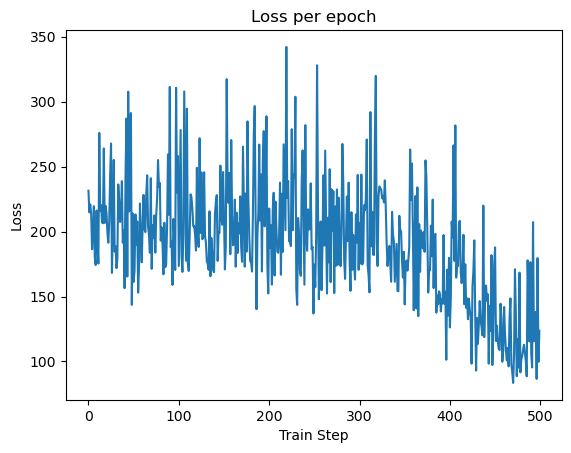

In [10]:
# Hyperparameters of the model.
num_slots = 7
num_iterations = 3
base_learning_rate = 0.0004
num_train_steps = 500
warmup_steps = 5
decay_rate = 0.5
decay_steps = 100000
#tf.random.set_seed(0)
resolution = (256, 256)

#checkpoint_path = "./training/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)


# Build optimizers and model
optimizer = tf.keras.optimizers.Adam(base_learning_rate, epsilon=1e-08)

#   model = build_model(resolution, batch_size, num_slots, num_iterations)

# Prepare checkpoint manager.
global_step = tf.Variable(0, trainable=False, name="global_step", dtype=tf.int64)

losses = []
val_losses = []

for _ in tqdm(range(num_train_steps), desc='Train Steps'):
    batch = next(train_iterator)
    val_batch = next(val_iterator)

    # Learning rate warm-up.
    if global_step < warmup_steps:
        learning_rate = base_learning_rate * tf.cast(global_step, tf.float32) / tf.cast(warmup_steps, tf.float32)
    else:
        learning_rate = base_learning_rate

    learning_rate = learning_rate * (decay_rate ** (tf.cast(global_step, tf.float32) / tf.cast(decay_steps, tf.float32)))
    optimizer.lr = learning_rate.numpy()

    loss_value = train_step(batch, model, optimizer)
    losses.append(loss_value)
    
    val_recon_combined, _, _, _ = model(val_batch, training=False)
    val_losses.append(l2_loss(val_recon_combined, val_batch))

    # Update the global step. We update it before logging the loss and saving
    # the model so that the last checkpoint is saved at the last iteration.
    global_step.assign_add(1)

visualize_loss(losses)

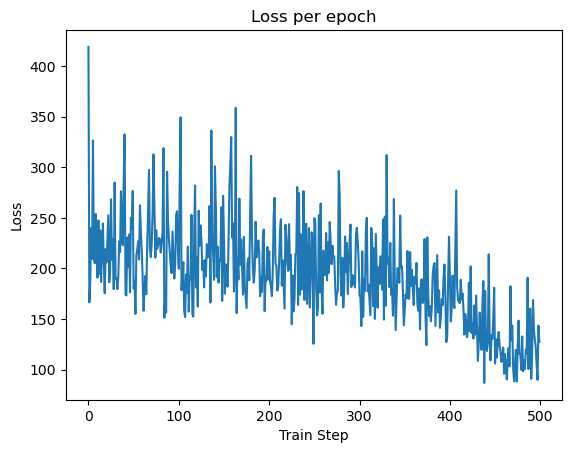

In [11]:
visualize_loss(val_losses)

In [12]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 255

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch)
  image = renormalize(batch)[idx]
  recon_combined = renormalize(recon_combined)[idx]
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots

In [20]:
batch = next(test_iterator)

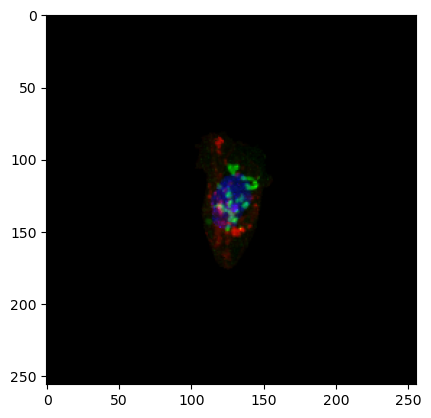

In [21]:
# Visualize.
plt.imshow(renormalize(batch)[0])

In [22]:
image, recon_combined, recons, masks, slots = get_prediction(model, batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


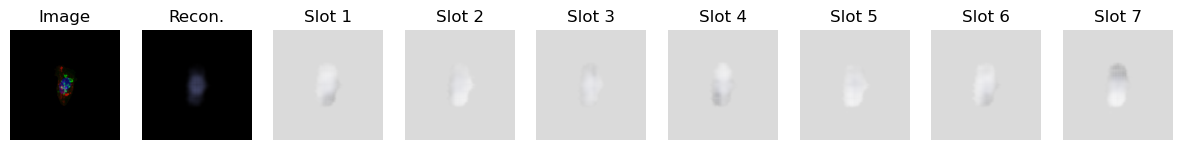

In [23]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


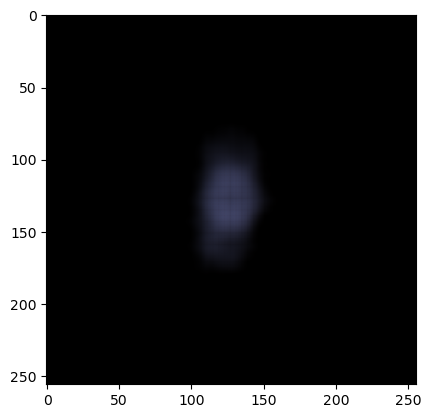

In [24]:
plt.imshow(recons[0])